<center><h1> ARIMA For Rainfall Data - Latur (Maharashtra) </h1></center>

<ul><h2> Contents</h2><br>
    <li><a href = "http://localhost:8888/notebooks/ARIMA.ipynb#1.-Import-libraries-">Import Libraries</a></li>
    <li><a href = "http://localhost:8888/notebooks/ARIMA.ipynb#2.-Read-and-Pre-process-Data-">Read and Pre-process Data</a>
        <ul>
        <li><a href="http://localhost:8888/notebooks/ARIMA.ipynb#2.1.-Convert-the-dataframe-according-to-time-series">Convert the dataframe according to time series</a></li>
        </ul>
    </li>
    <li><a href = "http://localhost:8888/notebooks/ARIMA.ipynb#3.-Visualize-the-Data">Visualize the Data</a></li>
    <li><a href="http://localhost:8888/notebooks/ARIMA.ipynb#4.-Tests-for-Stationarity">Tests for Stationarity</a>
        <ul>
        <li><a href="http://localhost:8888/notebooks/ARIMA.ipynb#4.1.-ADF-(Augmented-Dickey-Fuller)-Test">ADF (Augmented Dickey Fuller) Test</a></li>
        <li><a href="http://localhost:8888/notebooks/ARIMA.ipynb#4.2.-KPSS-(Kwiatkowski-Phillips-Schmidt-Shin)-Test">KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test</a></li>
        </ul>
        </li>
    <li><a href = "http://localhost:8888/notebooks/ARIMA.ipynb#5.-ACF-and-PACF-Plots">ACF and PACF Plots</a>
        <ul>
            <li><a href="http://localhost:8888/notebooks/ARIMA.ipynb#5.1-ACF-Plot">ACF Plot</a></li>
            <li><a href="http://localhost:8888/notebooks/ARIMA.ipynb#5.2-PACF-Plot">PACF Plot</a></li>
        </ul>
    </li>
    <li><a href = "http://localhost:8888/notebooks/ARIMA.ipynb#6.-Fitting-Model">Fitting Model</a></li>
</ul>

<h2>1. Import libraries </h2>

In [1]:
import warnings
import numpy as np
import pandas as pd
from matplotlib import pyplot
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

<h2>2. Read and Pre-process Data </h2>

In [2]:
data = pd.read_csv("precipitation_data.csv",sep="\t")
data.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1962,0.101,1.929,1.320,37.500,58.018,109.024,113.457,286.205,316.882,86.972,57.246,15.156
1,1963,0.000,5.253,16.215,23.023,26.511,209.793,133.198,367.777,95.537,120.212,0.286,0.000
2,1964,0.151,0.501,12.017,7.681,1.747,112.695,199.092,141.973,322.930,31.971,7.568,0.400
3,1965,0.272,0.082,0.000,2.093,0.966,116.539,180.015,133.094,118.691,2.840,1.850,12.475
4,1966,5.439,1.949,4.044,5.869,10.855,91.042,169.883,126.087,232.812,26.421,92.471,12.820


<h3>2.1. Convert the dataframe according to time series</h3>

In [3]:
months = data.columns
years = data.Year
Time = []
for year in years:
    for month in months:
        if(month!='Year'):
            Time.append(str(year)+" "+month)
Time = pd.Index(Time)            
# print Time
# print Time.shape

Values = []
for index, row in data.iterrows():
    r = []
    r = list(row)
    r.pop(0)
    Values.extend(r)

Values = pd.Index(Values)
# print Values
# print Values.shape

In [4]:
series = pd.DataFrame({'Time': Time, 'Values': Values})
dummy = series
dummy.head()

,Time,Values
0,1962 Jan,0.101
1,1962 Feb,1.929
2,1962 Mar,1.320
3,1962 Apr,37.500
4,1962 May,58.018


In [5]:
series.index = pd.to_datetime(series.Time)
series.drop(["Time"],axis=1)
series = series.drop(columns=['Time'])
series.head()

test_data = series.ix['1995':]
series = series.ix[: '1994']

/home/vubuntu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/vubuntu/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


<h2>3. Visualize the Data</h2>

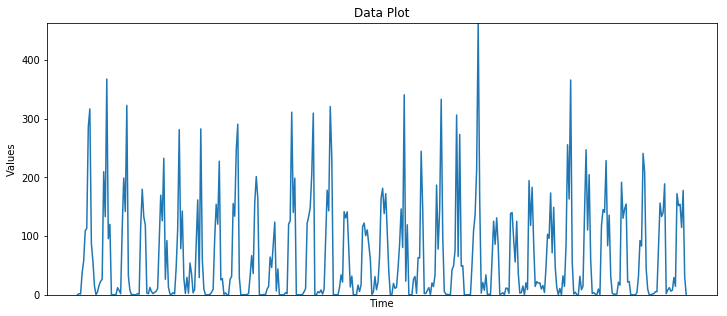

In [44]:
series_data = series.Values
minimum=series_data.min()
maximum=series_data.max()

pyplot.figure(figsize=(12,5))
series_data.plot()
axes = pyplot.gca()
axes.set_ylim([minimum,maximum]) #setes ticks on y-axis according to min and max 

pyplot.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

pyplot.title("Data Plot")
pyplot.xlabel("Time")
pyplot.ylabel("Values")

pyplot.show()

In [45]:
# checking the mean and variance for stationarity
X = series.Values
split = len(X) / 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=64.344247, mean2=67.854773
variance1=7223.797411, variance2=7076.927449


<p> Hence the series is stationary</p>

In [46]:
yearly_mean = series_data.rolling(window=12).mean()
yearly_std = series_data.rolling(window=12).std()


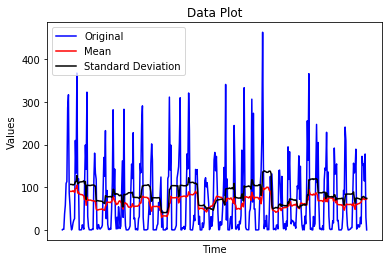

In [78]:
orig = pyplot.plot(series.Values,color='blue',label='Original')
mean = pyplot.plot(yearly_mean,color='red',label='Mean')
std = pyplot.plot(yearly_std,color='black',label='Standard Deviation')

pyplot.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

pyplot.title("Data Plot")
pyplot.xlabel("Time")
pyplot.ylabel("Values")


pyplot.legend(loc='best')

<h2>4. Tests for Stationarity</b>

<h3>4.1. ADF (Augmented Dickey Fuller) Test</h3><br>
The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

<b>Null Hypothesis:</b> The series has a unit root (value of a =1)<br>
<b>Alternate Hypothesis:</b> The series has no unit root.<br>
If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.<br>

<b><font color='blue'>If the <font color="magenta">test statistic &lt; critical value</font>, we can reject the null hypothesis <font color="magenta">(the series is stationary)</font>.<br> When the <font color="magenta">test statistic &gt; critical value</font>, we fail to reject the null hypothesis <font color="magenta">(the series is not stationary).</font></font></b>

<br><b><font color="green">Here, the Test Statistic  &lt; critical value. Hence the series is stationary</font></b>.<br>

In [48]:
#dickey-fuller test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(series_data)    

Results of Dickey-Fuller Test:
Test Statistic                  -4.229417
p-value                          0.000587
#Lags Used                      12.000000
Number of Observations Used    383.000000
Critical Value (5%)             -2.869116
Critical Value (1%)             -3.447540
Critical Value (10%)            -2.570806
dtype: float64


<h3>4.2. KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test</h3><br>
KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.<br>

<b>Null Hypothesis: The process is trend stationary.</b><br>
<b>Alternate Hypothesis: The series has a unit root (series is not stationary).</b>

In [49]:
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(series_data)

Results of KPSS Test:
Test Statistic            0.027364
p-value                   0.100000
Lags Used                17.000000
Critical Value (5%)       0.463000
Critical Value (1%)       0.739000
Critical Value (2.5%)     0.574000
Critical Value (10%)      0.347000
dtype: float64


/home/vubuntu/miniconda2/lib/python2.7/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


<b><font color='blue'>If the <font color="magenta">test statistic &gt; critical value</font>, we reject the null hypothesis <font color="magenta">(series is not stationary).</font><br> If the <font color="magenta"> test statistic &lt;  critical value</font>, if fail to reject the null hypothesis <font color="magenta">(series is stationary).</font></font></b>

It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

<b>Case 1:</b> Both tests conclude that the series is not stationary -> series is not stationary<br>
<b>Case 2:</b> Both tests conclude that the series is stationary -> series is stationary<br>
<b>Case 3:</b> KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary<br>
<b>Case 4:</b> KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary<br>

<b><font color="green"> Here, the Test statistic is less than critical value. Hence it is stationary</font></b>

<b><i> As the data is stationary, we don't need to go for any stationarity achieving processing like differencing. The data is ready enough to fit a prediction model </i></b>

<h2>5. ACF and PACF Plots</h2>

<p> <b>ARIMA(p,d,q)</b> denotes that it's parameters are p (order of AR process), d (differencing for stationarity),q (order of MA process. 
    
From the above, we know that d=0, since our data is already stationary.
    
Now we plot ACF and PACF plots in this session to determine p,q.</p>



<table align="left">
    <thead> 
        <tr> <th></th> 
            <th><font size="3"  padding="5">ACF</font></th> 
            <th><font size="3">PACF</font></th>  
        </tr> 
    </thead> 
    <tbody> 
        <tr> 
            <th scope='row'><font size="3">AR(p)</font></th> 
                <td height="50" padding="5"><font color="green" size="2">tails off exponentially</font></td> 
                <td height="50"><font color="green" size="2">cuts off at lag p</font></td>
        </tr> 
        <tr> 
            <th scope='row'><font size="3">MA(q)</font></th> 
                <td height="50"  padding="5"><font color="#ad6a13" size="2">cuts off at lag q</font></td>
                <td height="50"><font color="#ad6a13" size="2">tails off exponentially</font>
            </td> 
        </tr>
    </tbody>
    </table>
</center>

<h3>5.1 ACF Plot</h3>

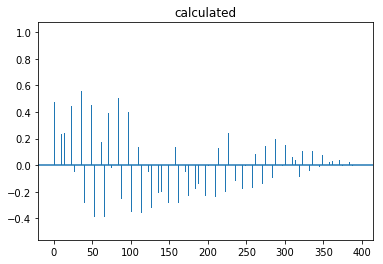

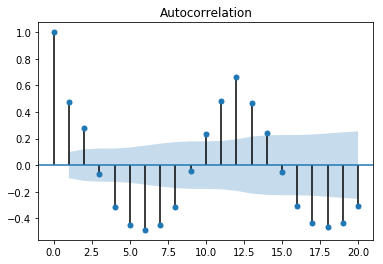

In [66]:
#extract data values
zt = np.array(series_data)

#mean of data
mean = np.mean(zt)

#variance of data
#var = zt.var()
c0 = np.sum((zt - mean)*(zt - mean))/len(zt)

#calculate lag-wise auto-correlation
corr_coeffs=[]
lags=[]
for k in range(len(zt)):
    series_1 = zt[k:]
    series_2 = zt[:len(zt)-k]
    
    if len(series_1)!=len(series_2):
        print "Error!!!"
    else:
        num = np.sum((series_1 - mean)*(series_2 - mean))
        den = c0*len(zt)
        coeff = num/den
        
        corr_coeffs.append(coeff)
        lags.append(k)

#print the corr_coeffs and lags
# print "************************"
# print "correlation coeffs: ",corr_coeffs
# print "------------"
# print "lags: ",lags
# print "************************"

#plot autocorr vs lag
pyplot.title("calculated")
pyplot.bar(lags,corr_coeffs,width=0.2)
pyplot.axhline(0)
pyplot.show()

#plot the same using in-built func
plot_acf(zt,lags=20)
pyplot.show()

<h3>5.2 PACF Plot</h3>

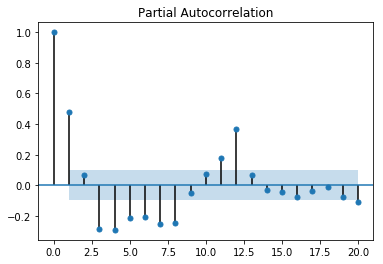

In [67]:
#plot pacf using in-built function
plot_pacf(zt,lags=20)
pyplot.show()	

Text(0.5,1,'PACF')

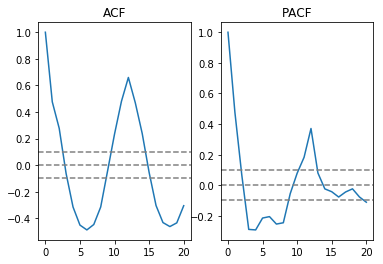

In [68]:
lag_acf = acf(series_data,nlags=20)
lag_pacf = pacf(series_data,nlags=20,method='ols')

pyplot.subplot(121)
pyplot.plot(lag_acf)
pyplot.axhline(y=0,linestyle='--',color='gray')
pyplot.axhline(y=-1.96/np.sqrt(len(series_data)),linestyle='--',color='gray')
pyplot.axhline(y=1.96/np.sqrt(len(series_data)),linestyle='--',color='gray')
pyplot.title("ACF")

pyplot.subplot(122)
pyplot.plot(lag_pacf)
pyplot.axhline(y=0,linestyle='--',color='gray')
pyplot.axhline(y=-1.96/np.sqrt(len(series_data)),linestyle='--',color='gray')
pyplot.axhline(y=1.96/np.sqrt(len(series_data)),linestyle='--',color='gray')
pyplot.title("PACF")

<h2>6. Fitting Model</h2>

In [69]:
best_pdq = (0, 1, 1)
best_seasonal_pdq = (0, 1, 1, 12)

best_model = sm.tsa.statespace.SARIMAX(series_data,
                                     order=best_pdq,
                                     seasonal_order=best_seasonal_pdq,
                                     enforce_stationarity=True,
                                     enforce_invertibility=True)
best_results = best_model.fit()

/home/vubuntu/miniconda2/lib/python2.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<b> Forecast</b>

In [70]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 36
pred_uc_95 = best_results.get_forecast(steps=n_steps, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% of the forecasts
pred_ci_95 = pred_uc_95.conf_int()

In [71]:
series_data.index

DatetimeIndex(['1962-01-01', '1962-02-01', '1962-03-01', '1962-04-01',
               '1962-05-01', '1962-06-01', '1962-07-01', '1962-08-01',
               '1962-09-01', '1962-10-01',
               ...
               '1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
               '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
               '1994-11-01', '1994-12-01'],
              dtype='datetime64[ns]', name=u'Time', length=396, freq=None)

In [72]:
index = pd.date_range('1994-12-01', periods=n_steps, freq='MS')
forecast_data = pd.DataFrame(np.column_stack([pred_uc_95.predicted_mean, pred_ci_95]), 
                    index=index, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])

forecast_data.head()

,forecast,lower_ci_95,upper_ci_95
1994-12-01,1.804554,-96.891877,100.500985
1995-01-01,5.206817,-93.489692,103.903326
1995-02-01,7.038294,-91.658289,105.734878
1995-03-01,12.311315,-86.385344,111.007973
1995-04-01,24.025483,-74.671250,122.722216


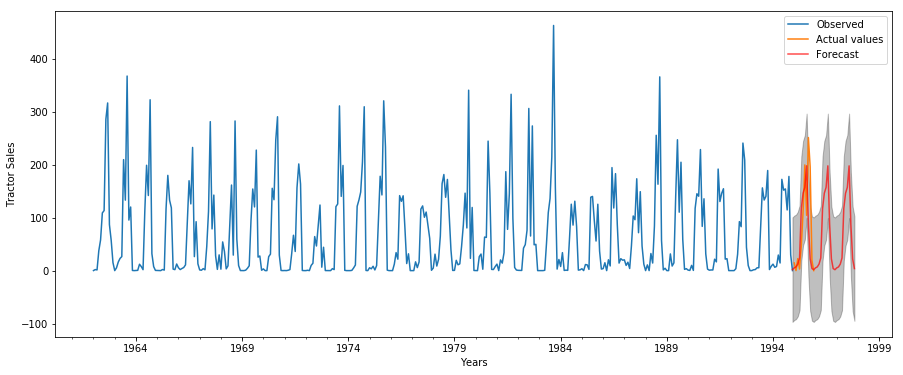

In [75]:
axis_plt = series_data['1962':].plot(label='Observed', figsize=(15, 6))

test_data.Values.plot(ax=axis_plt, label='Actual values')
forecast_data['forecast'].plot(ax=axis_plt, label='Forecast', alpha=0.7, color='r')

axis_plt.fill_between(forecast_data.index, forecast_data['lower_ci_95'], forecast_data['upper_ci_95'], color='k', alpha=.25)

axis_plt.set_xlabel('Years')
axis_plt.set_ylabel('Tractor Sales')
pyplot.legend(loc='best')

In [76]:
mse = ((test_data[:'1995-12-01'].Values - forecast_data['forecast']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 6221.5511
